In [1]:
from convokit import Corpus, download
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import nltk
import sys, os, re, time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from tensorflow import keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.activations import relu, sigmoid
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.initializers import Constant
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import plot_model
from sklearn.metrics import classification_report, confusion_matrix
from numpy import array
from collections import Counter

# NLTK Resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

print('Libraries Loaded')

Libraries Loaded
[nltk_data] Downloading package punkt to /home/buddha/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/buddha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/buddha/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:

# Text that invalidates the whole row.
rowInvalidationText = ['', ' ', '[deleted]', '[removed]']
# Additional stopwords
extraStopwords = set(
    ['reddit', 'redditor', 'reddits', 'subreddit', 'subreddits'])

emotionOther = ['love', 'surprise']

# Variables for cleaner() method
stemmer = PorterStemmer() # Stemmer
lem = WordNetLemmatizer()  # Lematizer
prelimStopwords = []
stopWordList = set(stopwords.words('english')).union(
    extraStopwords)  # List of Stopwords
minWordLength = 3  # Minimum word length
maxWordCount = 30  # Maximum words per post

def dataFrameStatus(df: pd.DataFrame):
    print(f'Dataframe shape: {df.shape}')
    for name, _ in df.iteritems():
        print(f'Number of {name}: {df[name].nunique()}')
    print(df.sample(5),'\n')


# Remove invalid posts
def removeInvalidPosts(df: pd.DataFrame, invalidTextList: list) -> pd.DataFrame:
    for invalidText in invalidTextList:
        for name, _ in df.iteritems():
            df = df[df[name] != invalidText]
    df = df.reset_index(drop=True)
    return df


def rawCleaner(post: str):
    post = re.sub(r'http\S+', '', post)  # Remove URLs
    post = re.sub(r'[^a-zA-Z\s]', '', post)  # Remove Non-letters
    post = post.lower()  # All to Lowercase
    post = word_tokenize(post)  # Tokenize text
    post = [word for word in post if word not in extraStopwords]  # Extra SWs
    post = post[:maxWordCount]  # Limit word count (Post-Token Method)
    post = ' '.join(post)  # Rejoin token into a single string
    sys.stdout.write(f'\r{post[:30]}...')
    return post


def nlpTreatment(entry: str, lemmatizer_over_stemmer: bool = True):
    entry = word_tokenize(entry)  # Tokenize text
    entry = [word for word in entry if word not in stopWordList] # All Stopwords
    if (lemmatizer_over_stemmer):
        entry = [lem.lemmatize(word=word, pos='v') for word in entry]  # Lematize
    else:
        entry = [stemmer.stem(entry) for word in entry] # Stem
    entry = [word for word in entry if len(word) >= minWordLength]  # No short words
    entry = ' '.join(entry)
    sys.stdout.write(f'\r{entry[:30]}...')
    return entry


def cleanDF(df: pd.DataFrame, rowInvalidationText: list) -> pd.DataFrame:
    tick = time.time()
    df = removeInvalidPosts(df, rowInvalidationText)
    for name, _ in df.iteritems():
        sys.stdout.write(f'Cleaning raw column "{name}"...\n')
        start = time.time()
        df[name] = df[name].apply(rawCleaner)
        end = time.time()
        sys.stdout.write(
            '\r\rColumn "{}" cleaned ({:.2f}s) ✓\n'.format(name, end - start))
        sys.stdout.flush()
    # removeInvalidPosts() is executed twice because it is possible for the clean()
    # function to return a now invalid value, which would invalidate the row.
    df = removeInvalidPosts(df, rowInvalidationText)
    tock = time.time()
    print('Finished preprocessing ({:.2f}s Total)\n'.format(tock-tick))
    return df


def ednlpSplitter(df: pd.DataFrame, headers: list) -> set:
    global e_index
    sys.stdout.write('Cleaning for NLP...\n')
    tick=time.time()
    X = df[headers[0]].apply(nlpTreatment)
    tock = time.time()
    y = df[headers[1]]
    for drop in emotionOther:
        y = y.replace(drop, 'other')
    y, e_index = pd.factorize(y, sort=True)
    sys.stdout.write('\r\rDone ✓. ({:.2f}s)\n'.format(tock - tick))
    sys.stdout.flush()
    return X, y


def counter_word(texts) -> int:
    count = Counter()
    for text in texts.values:
        for word in text.split():
            count[word] += 1
    return count


def decodeWordIndex(text, wordIndex):
    reverse_word_index = dict([(value, key) for (key, value) in wordIndex.items()])
    return ' '.join([reverse_word_index.get(i, "?") for i in text])


def plot_confussion_matrix(data, labels, name='output', title='Confussion Matrix', annot=True, fmt='.2f', ylabel='True', xlabel='Predicted'):
    sb.set(color_codes=True)
    plt.figure(1, figsize=(6, 5))
    plt.title = (f'{name} - {title}')
    
    ax = sb.heatmap(data, annot=annot, cmap='BuPu', linecolor='black', fmt=fmt, square=True)
    
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    ax.set_title(f'{name} {title}')

    ax.set(ylabel=ylabel, xlabel=xlabel)

    plt.savefig(f'images/{name} {title}.png', bboc_inches='tight', dpi=300)
    plt.show()
    plt.close()
    

def predictAndChoose(model, data):
    data = model.predict(data, verbose=1)
    data = data.argmax(axis=1)
    return data


def sequencerPadder(data, tokenizer):
    sequence = tokenizer.texts_to_sequences(data) # Features as Sequences
    paddedSequence = pad_sequences(sequence, maxlen=maxWordCount, padding='post', truncating='post') #Features as Padded Sequences
    return sequence, paddedSequence

print("Utility and Preprocessing Functions loaded.")


Utility and Preprocessing Functions loaded.


In [3]:

headers = ['post', 'reply']
# If the dataset already exists, just move on to the next step.
# Otherwise, download and preprocess from convokit corpus
try:
    mhd = pd.read_csv('dataset/mental_health.csv')
    mhd = mhd.reset_index(drop=True)
    print('Mental Health Data found and Loaded\n')
except:
    print('Mental Health Dataset not found. Constructing Dataset. This might take a while...')
    tick = time.time()
    target_subreddit = 'subreddit-mentalhealth'
    corpus = Corpus(download(target_subreddit))
    corpus.print_summary_stats()
    rawDataList = []
    for uID in corpus.get_utterance_ids():
        # Only evaluate for utterances that are, themselves, replies.
        if (corpus.get_utterance(uID).reply_to != None):
            try:
                reply = corpus.get_utterance(uID)
                post = corpus.get_utterance(reply.reply_to)
            except:
                pass
            rawDataList.append([post.text, reply.text])
    mhd = pd.DataFrame(rawDataList, columns=headers)
    mhd = cleanDF(mhd, rowInvalidationText)
    mhd.to_csv('dataset/mental_health.csv', index=False)
    tock = time.time()
    print('Dataset written. ({:.2f}s)\n'.format(tock-tick))

dataFrameStatus(mhd)

Mental Health Data found and Loaded

Dataframe shape: (162647, 2)
Number of post: 108328
Number of reply: 157816
                                                     post  \
107277  i have a similar kind of situation i dont clea...   
29626   sounds like you may have a substance problem t...   
7025    hello im looking for advice on how to overcome...   
122772  musa im sure im not the only one with this pro...   
140664  yes seriously im not here to peddle you some n...   

                                                    reply  
107277  to you op and every other person thats experie...  
29626              i havent taken anything in about weeks  
7025            see my answer to your post in rneedadvice  
122772                           any meds past or current  
140664  is this a test that can be done at your yearly...   



In [4]:
# Loading EDNLP Data
ec_colnames = ['text', 'emotion']
try:
    ec_train = pd.read_csv('dataset/EDNLP/train.csv', names=ec_colnames, sep=";")
    ec_test = pd.read_csv('dataset/EDNLP/test.csv', names=ec_colnames, sep=";")
    ec_val = pd.read_csv('dataset/EDNLP/val.csv', names=ec_colnames, sep=";")
    print('EDNLP Datasets loaded.')


    ec_train_X, ec_train_y = ednlpSplitter(ec_train, ec_colnames)
    ec_test_X, ec_test_y = ednlpSplitter(ec_test, ec_colnames)
    ec_val_X, ec_val_y = ednlpSplitter(ec_val, ec_colnames)

    ednlp = {
        'tr': {'X': ec_train_X, 'y': ec_train_y}, # Training Sets
        'te': {'X': ec_test_X, 'y': ec_test_y}, # Testing Sets
        'va': {'X': ec_val_X, 'y': ec_val_y} #Validation Sets
    }
    print()
    for key in ednlp:
        print('Shape of',key,'\b features:',ednlp[key]['X'].shape)
except:
    print('EDNLP Datasets not found. check for test, val and train CSVs at /dataset/EDNLP')

EDNLP Datasets loaded.
Cleaning for NLP...
Done ✓. (5.74s)
Cleaning for NLP...
Done ✓. (0.49s)
Cleaning for NLP...
Done ✓. (0.46s)

Shape of tr features: (16000,)
Shape of te features: (2000,)
Shape of va features: (2000,)


In [5]:
wordCounter = counter_word(ednlp['tr']['X'])
numWords = len(wordCounter)

tokenizer = Tokenizer(num_words=numWords)
tokenizer.fit_on_texts(ednlp['tr']['X'])
word_index = tokenizer.word_index

for key in ednlp:
    ednlp[key]['Xs'], ednlp[key]['Xp'] = sequencerPadder(ednlp[key]['X'], tokenizer)

print('Sequences and Padded Sequences generated.')

Sequences and Padded Sequences generated.


EDNLP_BLSTM Model loaded.

Model: "EDNLP_BLSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 32)            381888    
_________________________________________________________________
blstm (Bidirectional)        (None, 86)                26144     
_________________________________________________________________
dense (Dense)                (None, 5)                 435       
Total params: 408,467
Trainable params: 408,467
Non-trainable params: 0
_________________________________________________________________
None


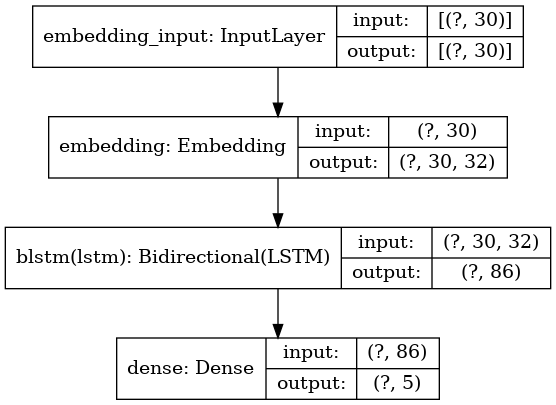

In [6]:
try:
    model = keras.models.load_model('models/EDNLP_BLSTM')
    print('EDNLP_BLSTM Model loaded.\n')
except:
    print('EDNLP_BLSTM Model not found on models/EDNLP_BLSTM. Building model.')
    # Model Structure
    model = Sequential(name='EDNLP_BLSTM')

    scaleFactor = 8
    embedOutput = 32

    lstmUnits = int(round(
        len(ednlp['tr']['Xp'])
        /
        (scaleFactor * (len(e_index) + embedOutput))
    ))

    print('Target Outputs for unidirectional LSTM Layer:',lstmUnits)

    model.add(Embedding(numWords, embedOutput, input_length=maxWordCount, name='embedding'))
    model.add(Bidirectional(LSTM(lstmUnits, dropout=0.1), name='blstm'))
    model.add(Dense(len(e_index), activation='sigmoid', name='dense'))

    model.get_layer('embedding')

    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer = Adam(learning_rate=3e-4),
        metrics=['accuracy'])

    #Model Training
    history =  model.fit(
        ednlp['tr']['Xp'], ednlp['tr']['y'],
        epochs=21,
        use_multiprocessing=True,
        validation_data=(ednlp['va']['Xp'], ednlp['va']['y'])
    )
    # Save model
    print('Saving model...\n')
    model.save('models/EDNLP_BLSTM')

print(model.summary())
plot_model(model, to_file='images/BLSTM_model.png', show_layer_names=True, show_shapes=True)

63/63 [==============================] - 1s 12ms/step
              precision    recall  f1-score   support
anger          0.847737  0.749091  0.795367   275.000
fear           0.854271  0.758929  0.803783   224.000
joy            0.850360  0.850360  0.850360   695.000
other          0.612000  0.680000  0.644211   225.000
sadness        0.831974  0.877797  0.854271   581.000
accuracy       0.815000  0.815000  0.815000     0.815
macro avg      0.799268  0.783235  0.789598  2000.000
weighted avg   0.818281  0.815000  0.815526  2000.000


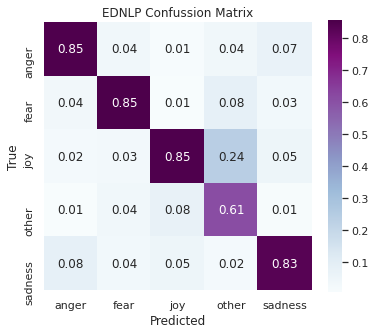

In [7]:
testPrediction = predictAndChoose(model, ednlp['te']['Xp'])

# Presicion, Recall, F1-Score, Confussion Matrix
ednlp_cm=confusion_matrix(ednlp['te']['y'], testPrediction, normalize='pred')

report=classification_report(ednlp['te']['y'], testPrediction, target_names=e_index, output_dict=True)
report=pd.DataFrame(report).transpose()
report.to_csv('reports/ednlp.csv', float_format='%.2f')
print(report)

plot_confussion_matrix(ednlp_cm, e_index, name='EDNLP', fmt='.2f')


In [8]:
eHeaders=['post', 'reply', 'post_emotion', 'reply_emotion']
try:
    emhd = pd.read_csv('dataset/emotional_mental_health.csv')
    emhd = emhd.reset_index(drop=True)
    print('Emotionally annotated dataset (EMHD) loaded')
#Begin annotating MHD into EMHD
except:
    print('EMHD Not found. Contructing.')
    emhd=mhd
    for name, _ in mhd.iteritems():
        sys.stdout.write(f'Annotating column "{name}" with emotion...\n')
        start = time.time()
        treated = mhd[name].apply(nlpTreatment)  # First apply NLP treatment
        _, pSeq = sequencerPadder(treated, tokenizer) # Store padded sequences
        emhd[f'{name}_emotion'] = predictAndChoose(model, pSeq) # Predict and annotate
        end = time.time()
        sys.stdout.write(
            '\r\rColumn "{}" annotated. ({:.2f}s) ✓\n'.format(name, end - start))
        sys.stdout.flush()
    emhd.to_csv('dataset/emotional_mental_health.csv', index=False)

dataFrameStatus(emhd)


EMHD Not found. Contructing.
Annotating column "post" with emotion...
still relatively young damn aw...

KeyboardInterrupt: 

In [1]:
from convokit import Corpus, download
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import nltk
import sys, os, re, time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from tensorflow import keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.activations import relu, sigmoid
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.initializers import Constant
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import plot_model
from sklearn.metrics import classification_report, confusion_matrix
from numpy import array
from collections import Counter

# NLTK Resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

print('Libraries Loaded')

Libraries Loaded
[nltk_data] Downloading package punkt to /home/buddha/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/buddha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/buddha/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:

# Text that invalidates the whole row.
rowInvalidationText = ['', ' ', '[deleted]', '[removed]']
# Additional stopwords
extraStopwords = set(
    ['reddit', 'redditor', 'reddits', 'subreddit', 'subreddits'])

emotionOther = ['love', 'surprise']

# Variables for cleaner() method
stemmer = PorterStemmer() # Stemmer
lem = WordNetLemmatizer()  # Lematizer
prelimStopwords = []
stopWordList = set(stopwords.words('english')).union(
    extraStopwords)  # List of Stopwords
minWordLength = 3  # Minimum word length
maxWordCount = 30  # Maximum words per post

def dataFrameStatus(df: pd.DataFrame):
    print(f'Dataframe shape: {df.shape}')
    for name, _ in df.iteritems():
        print(f'Number of {name}: {df[name].nunique()}')
    print(df.sample(5),'\n')


# Remove invalid posts
def removeInvalidPosts(df: pd.DataFrame, invalidTextList: list) -> pd.DataFrame:
    for invalidText in invalidTextList:
        for name, _ in df.iteritems():
            df = df[df[name] != invalidText]
    df = df.reset_index(drop=True)
    return df


def rawCleaner(post: str):
    post = re.sub(r'http\S+', '', post)  # Remove URLs
    post = re.sub(r'[^a-zA-Z\s]', '', post)  # Remove Non-letters
    post = post.lower()  # All to Lowercase
    post = word_tokenize(post)  # Tokenize text
    post = [word for word in post if word not in extraStopwords]  # Extra SWs
    post = post[:maxWordCount]  # Limit word count (Post-Token Method)
    post = ' '.join(post)  # Rejoin token into a single string
    sys.stdout.write(f'\r{post[:30]}...')
    return post


def nlpTreatment(entry: str, lemmatizer_over_stemmer: bool = True):
    entry = word_tokenize(entry)  # Tokenize text
    entry = [word for word in entry if word not in stopWordList] # All Stopwords
    if (lemmatizer_over_stemmer):
        entry = [lem.lemmatize(word=word, pos='v') for word in entry]  # Lematize
    else:
        entry = [stemmer.stem(entry) for word in entry] # Stem
    entry = [word for word in entry if len(word) >= minWordLength]  # No short words
    entry = ' '.join(entry)
    sys.stdout.write(f'\r{entry[:30]}...')
    return entry


def cleanDF(df: pd.DataFrame, rowInvalidationText: list) -> pd.DataFrame:
    tick = time.time()
    df = removeInvalidPosts(df, rowInvalidationText)
    for name, _ in df.iteritems():
        sys.stdout.write(f'Cleaning raw column "{name}"...\n')
        start = time.time()
        df[name] = df[name].apply(rawCleaner)
        end = time.time()
        sys.stdout.write(
            '\r\rColumn "{}" cleaned ({:.2f}s) ✓\n'.format(name, end - start))
        sys.stdout.flush()
    # removeInvalidPosts() is executed twice because it is possible for the clean()
    # function to return a now invalid value, which would invalidate the row.
    df = removeInvalidPosts(df, rowInvalidationText)
    tock = time.time()
    print('Finished preprocessing ({:.2f}s Total)\n'.format(tock-tick))
    return df


def ednlpSplitter(df: pd.DataFrame, headers: list) -> set:
    global e_index
    sys.stdout.write('Cleaning for NLP...\n')
    tick=time.time()
    X = df[headers[0]].apply(nlpTreatment)
    tock = time.time()
    y = df[headers[1]]
    for drop in emotionOther:
        y = y.replace(drop, 'other')
    y, e_index = pd.factorize(y, sort=True)
    sys.stdout.write('\r\rDone ✓. ({:.2f}s)\n'.format(tock - tick))
    sys.stdout.flush()
    return X, y


def counter_word(texts) -> int:
    count = Counter()
    for text in texts.values:
        for word in text.split():
            count[word] += 1
    return count


def decodeWordIndex(text, wordIndex):
    reverse_word_index = dict([(value, key) for (key, value) in wordIndex.items()])
    return ' '.join([reverse_word_index.get(i, "?") for i in text])


def plot_confussion_matrix(data, labels, name='output', title='Confussion Matrix', annot=True, fmt='.2f', ylabel='True', xlabel='Predicted'):
    sb.set(color_codes=True)
    plt.figure(1, figsize=(6, 5))
    plt.title = (f'{name} - {title}')
    
    ax = sb.heatmap(data, annot=annot, cmap='BuPu', linecolor='black', fmt=fmt, square=True)
    
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    ax.set_title(f'{name} {title}')

    ax.set(ylabel=ylabel, xlabel=xlabel)

    plt.savefig(f'images/{name} {title}.png', bboc_inches='tight', dpi=300)
    plt.show()
    plt.close()
    

def predictAndChoose(model, data):
    data = model.predict(data, verbose=1)
    data = data.argmax(axis=1)
    return data


def sequencerPadder(data, tokenizer):
    sequence = tokenizer.texts_to_sequences(data) # Features as Sequences
    paddedSequence = pad_sequences(sequence, maxlen=maxWordCount, padding='post', truncating='post') #Features as Padded Sequences
    return sequence, paddedSequence

print("Utility and Preprocessing Functions loaded.")


Utility and Preprocessing Functions loaded.


In [3]:

headers = ['post', 'reply']
# If the dataset already exists, just move on to the next step.
# Otherwise, download and preprocess from convokit corpus
try:
    mhd = pd.read_csv('dataset/mental_health.csv')
    mhd = mhd.reset_index(drop=True)
    print('Mental Health Data found and Loaded\n')
except:
    print('Mental Health Dataset not found. Constructing Dataset. This might take a while...')
    tick = time.time()
    target_subreddit = 'subreddit-mentalhealth'
    corpus = Corpus(download(target_subreddit))
    corpus.print_summary_stats()
    rawDataList = []
    for uID in corpus.get_utterance_ids():
        # Only evaluate for utterances that are, themselves, replies.
        if (corpus.get_utterance(uID).reply_to != None):
            try:
                reply = corpus.get_utterance(uID)
                post = corpus.get_utterance(reply.reply_to)
            except:
                pass
            rawDataList.append([post.text, reply.text])
    mhd = pd.DataFrame(rawDataList, columns=headers)
    mhd = cleanDF(mhd, rowInvalidationText)
    mhd.to_csv('dataset/mental_health.csv', index=False)
    tock = time.time()
    print('Dataset written. ({:.2f}s)\n'.format(tock-tick))

dataFrameStatus(mhd)

Mental Health Data found and Loaded

Dataframe shape: (162647, 2)
Number of post: 108328
Number of reply: 157816
                                                     post  \
71329   i live in los angeles and all the therapists i...   
153536  i was working on a project and i was called fo...   
73408   only thing about calling police that bothers m...   
40684   hard to say what causes this but i agree about...   
66320   this is my first post here and i dont even kno...   

                                                    reply  
71329   look and see if there are any counseling cente...  
153536  i dont want to scare you and i can not diagnos...  
73408   i already called the police due to advice here...  
40684   also see if you can have a neuropsych evaluati...  
66320   are there any programs outside of this shithol...   



In [4]:
# Loading EDNLP Data
ec_colnames = ['text', 'emotion']
try:
    ec_train = pd.read_csv('dataset/EDNLP/train.csv', names=ec_colnames, sep=";")
    ec_test = pd.read_csv('dataset/EDNLP/test.csv', names=ec_colnames, sep=";")
    ec_val = pd.read_csv('dataset/EDNLP/val.csv', names=ec_colnames, sep=";")
    print('EDNLP Datasets loaded.')


    ec_train_X, ec_train_y = ednlpSplitter(ec_train, ec_colnames)
    ec_test_X, ec_test_y = ednlpSplitter(ec_test, ec_colnames)
    ec_val_X, ec_val_y = ednlpSplitter(ec_val, ec_colnames)

    ednlp = {
        'tr': {'X': ec_train_X, 'y': ec_train_y}, # Training Sets
        'te': {'X': ec_test_X, 'y': ec_test_y}, # Testing Sets
        'va': {'X': ec_val_X, 'y': ec_val_y} #Validation Sets
    }
    print()
    for key in ednlp:
        print('Shape of',key,'\b features:',ednlp[key]['X'].shape)
except:
    print('EDNLP Datasets not found. check for test, val and train CSVs at /dataset/EDNLP')

EDNLP Datasets loaded.
Cleaning for NLP...
Done ✓. (5.56s)
Cleaning for NLP...
Done ✓. (0.48s)
Cleaning for NLP...
Done ✓. (0.53s)

Shape of tr features: (16000,)
Shape of te features: (2000,)
Shape of va features: (2000,)


In [5]:
wordCounter = counter_word(ednlp['tr']['X'])
numWords = len(wordCounter)

tokenizer = Tokenizer(num_words=numWords)
tokenizer.fit_on_texts(ednlp['tr']['X'])
word_index = tokenizer.word_index

for key in ednlp:
    ednlp[key]['Xs'], ednlp[key]['Xp'] = sequencerPadder(ednlp[key]['X'], tokenizer)

print('Sequences and Padded Sequences generated.')

Sequences and Padded Sequences generated.


EDNLP_BLSTM Model not found on models/EDNLP_BLSTM. Building model.
Target Outputs for unidirectional LSTM Layer: 54
Epoch 1/21
500/500 [==============================] - 15s 29ms/step - loss: 1.4561 - accuracy: 0.3473 - val_loss: 1.2004 - val_accuracy: 0.3985
Epoch 2/21
500/500 [==============================] - 14s 28ms/step - loss: 1.0432 - accuracy: 0.4616 - val_loss: 1.0445 - val_accuracy: 0.4490
Epoch 3/21
500/500 [==============================] - 14s 28ms/step - loss: 0.6937 - accuracy: 0.7418 - val_loss: 0.6581 - val_accuracy: 0.7800
Epoch 4/21
500/500 [==============================] - 14s 28ms/step - loss: 0.3931 - accuracy: 0.8799 - val_loss: 0.5696 - val_accuracy: 0.8265
Epoch 5/21
500/500 [==============================] - 14s 28ms/step - loss: 0.2982 - accuracy: 0.9081 - val_loss: 0.5575 - val_accuracy: 0.8270
Epoch 6/21
500/500 [==============================] - 14s 28ms/step - loss: 0.2391 - accuracy: 0.9293 - val_loss: 0.5502 - val_accuracy: 0.8215
Epoch 7/21
500/500 [

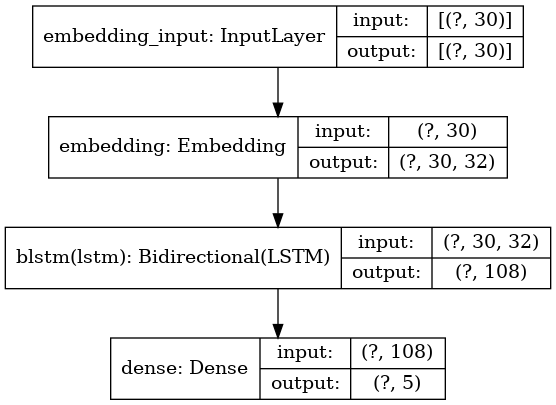

In [6]:
try:
    model = keras.models.load_model('models/EDNLP_BLSTM')
    print('EDNLP_BLSTM Model loaded.\n')
except:
    print('EDNLP_BLSTM Model not found on models/EDNLP_BLSTM. Building model.')
    # Model Structure
    model = Sequential(name='EDNLP_BLSTM')

    scaleFactor = 8
    embedOutput = 32

    lstmUnits = int(round(
        len(ednlp['tr']['Xp'])
        /
        (scaleFactor * (len(e_index) + embedOutput))
    ))

    print('Target Outputs for unidirectional LSTM Layer:',lstmUnits)

    model.add(Embedding(numWords, embedOutput, input_length=maxWordCount, name='embedding'))
    model.add(Bidirectional(LSTM(lstmUnits, dropout=0.1), name='blstm'))
    model.add(Dense(len(e_index), activation='sigmoid', name='dense'))

    model.get_layer('embedding')

    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer = Adam(learning_rate=3e-4),
        metrics=['accuracy'])

    #Model Training
    history =  model.fit(
        ednlp['tr']['Xp'], ednlp['tr']['y'],
        epochs=21,
        use_multiprocessing=True,
        validation_data=(ednlp['va']['Xp'], ednlp['va']['y'])
    )
    # Save model
    print('Saving model...\n')
    model.save('models/EDNLP_BLSTM')

print(model.summary())
plot_model(model, to_file='images/BLSTM_model.png', show_layer_names=True, show_shapes=True)

63/63 [==============================] - 1s 9ms/step
              precision    recall  f1-score   support
anger          0.860902  0.832727  0.846580   275.000
fear           0.780083  0.839286  0.808602   224.000
joy            0.914557  0.831655  0.871138   695.000
other          0.606498  0.746667  0.669323   225.000
sadness        0.902397  0.907057  0.904721   581.000
accuracy       0.845000  0.845000  0.845000     0.845
macro avg      0.812888  0.831478  0.820073  2000.000
weighted avg   0.853929  0.845000  0.847809  2000.000


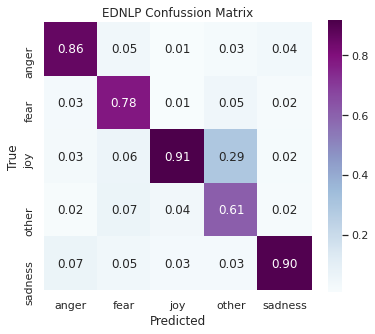

In [7]:
testPrediction = predictAndChoose(model, ednlp['te']['Xp'])

# Presicion, Recall, F1-Score, Confussion Matrix
ednlp_cm=confusion_matrix(ednlp['te']['y'], testPrediction, normalize='pred')

report=classification_report(ednlp['te']['y'], testPrediction, target_names=e_index, output_dict=True)
report=pd.DataFrame(report).transpose()
report.to_csv('reports/ednlp.csv', float_format='%.2f')
print(report)

plot_confussion_matrix(ednlp_cm, e_index, name='EDNLP', fmt='.2f')


In [8]:
eHeaders=['post', 'reply', 'post_emotion', 'reply_emotion']
try:
    emhd = pd.read_csv('dataset/emotional_mental_health.csv')
    emhd = emhd.reset_index(drop=True)
    print('Emotionally annotated dataset (EMHD) loaded')
#Begin annotating MHD into EMHD
except:
    print('EMHD Not found. Contructing.')
    emhd=mhd
    for name, _ in mhd.iteritems():
        sys.stdout.write(f'Annotating column "{name}" with emotion...\n')
        start = time.time()
        treated = mhd[name].apply(nlpTreatment)  # First apply NLP treatment
        _, pSeq = sequencerPadder(treated, tokenizer) # Store padded sequences
        emhd[f'{name}_emotion'] = predictAndChoose(model, pSeq) # Predict and annotate
        end = time.time()
        sys.stdout.write(
            '\r\rColumn "{}" annotated. ({:.2f}s) ✓\n'.format(name, end - start))
        sys.stdout.flush()
    emhd.to_csv('dataset/emotional_mental_health.csv', index=False)

dataFrameStatus(emhd)


EMHD Not found. Contructing.
Annotating column "post" with emotion...
5083/5083 [==============================] - 40s 8ms/step
Column "post" annotated. (91.34s) ✓
Annotating column "reply" with emotion...
5083/5083 [==============================] - 39s 8ms/step
Column "reply" annotated. (88.02s) ✓
Dataframe shape: (162647, 4)
Number of post: 108328
Number of reply: 157816
Number of post_emotion: 5
Number of reply_emotion: 5
                                                     post  \
138624  im a registered nurse who graduated at the top...   
36937   its more than two times really and no it was n...   
23160   i make a mistake and start beating myself up a...   
117164  its hard to explain but i can make myself be t...   
107720  is it necessary to forgive him i feel like you...   

                                                    reply  post_emotion  \
138624  im a yofemale and i used to work for a doctor ...             3   
36937   shrug lots of people cant drink like me its n

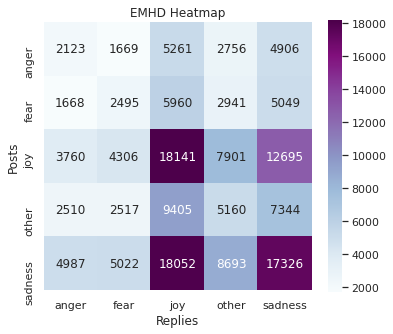

In [9]:
emhd_cm = confusion_matrix(emhd['post_emotion'], emhd['reply_emotion'], normalize=None)

plot_confussion_matrix(emhd_cm, e_index, name='EMHD', title='Heatmap', ylabel='Posts', xlabel='Replies', fmt='d')